## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# Loading necessary packages and setting a seed.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
((df.landing_page!='new_page')&(df.group=='treatment')).sum()

1965

f. Do any of the rows have missing values?

In [7]:
print("Number of rows with missing values: {}".format(df[df.isnull().any(axis=1)].shape[0]))

Number of rows with missing values: 0


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
## condition 1: user in treatment group has new page as landing page
c1 = (df.group=='treatment')&(df.landing_page=='new_page') 
## condition 2: user in control group has old page as landing page
c2 = (df.group=='control')&(df.landing_page=='old_page') 
## new data frame satisfying aboive two conditions
df2 = df[c1|c2]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.groupby('user_id').count().reset_index().sort_values('group', ascending = False).head(1)

,user_id,timestamp,group,landing_page,converted
131712,773192,2,2,2,2


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Removing one of the rows with a duplicate user_id. I removed row with index 1899
df2 = df2.drop(index=1899, axis=0)
# Check again if the row with a duplicate user_id is deleted or not
df2.shape[0]==df2.user_id.nunique()

True

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
p = df2.converted.mean()
print("Unconditional probablity of converting: {}".format(np.round(p,4)))

Unconditional probablity of converting: 0.1196


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
pc = df2[df2.group=="control"]['converted'].mean()
print("Probablity of converting if user is in control group: {}".format(np.round(pc,4)))

Probablity of converting if user is in control group: 0.1204


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
pt = df2[df2.group=="treatment"]['converted'].mean()
print("Probablity of converting if user is in treatment group: {}".format(np.round(pt,4)))

Probablity of converting if user is in treatment group: 0.1188


d. What is the probability that an individual received the new page?

In [17]:
pn = (df2.landing_page=='new_page').mean()
print("Probablity of a user being in a treatment group: {}".format(np.round(pn,4)))

Probablity of a user being in a treatment group: 0.5001


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> **Preliminary conclusion**

> From above calculation we see that there is not much difference in converstion probablity per groups. In fact, conversion probablity is marginally greater for the control group. Given that the probability of receiving new page (or being in a group of treatment) is 50%, the preliminary conclusion is against using the new page. However, this analysis seems limited since we do not know whether current observed difference in conversion rate is consistent for any periods or just a coincidence with current whole period. Moreover, we do not have any characteristics of an average user within groups. If they are different our estimates might not be correct, since we are comparing different people (apples to lemons).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> $H_{0}: p_{old} \geq p_{new}$

> $H_{1}: p_{old} < p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
pnew = df2[df2.group=='control']['converted'].mean()
print("Convert rate under null hypothises: {}".format(np.round(pnew,4)))

Convert rate under null hypothises: 0.1204


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
pold = pnew
print("Convert rate under null hypothises is same for both groups: {}".format(np.round(pold,4)))

Convert rate under null hypothises is same for both groups: 0.1204


c. What is $n_{new}$?

In [20]:
nnew = (df2.group=='treatment').sum()
print("Number of users in the treatment group: {}".format(nnew))

Number of users in the treatment group: 145310


d. What is $n_{old}$?

In [21]:
nold = (df2.group=='control').sum()
print("Number of users in the control group: {}".format(nold))

Number of users in the control group: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
## Simulation using random choice model and allowing to sample drawing with replacement.
new_page_converted = np.random.choice(2, nnew, replace = True, p=[1-pnew, pnew])
print("Convert rate for simulated treatement group: {}".format(np.round(new_page_converted.mean(),4)))

Convert rate for simulated treatement group: 0.1211


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice(2, nold, replace = True, p=[1-pold, pold])
print("Convert rate for simulated control group: {}".format(np.round(old_page_converted.mean(),4)))

Convert rate for simulated control group: 0.1205


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff_s = new_page_converted.mean() - old_page_converted.mean()
print("Diffirence in convert rates for simulated groups: {}".format(np.round(diff_s,4)))

Diffirence in convert rates for simulated groups: 0.0006


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
## simulating 10000 convertion rates for simulated treatment and control group
npcs = np.random.binomial(nnew, pnew, 10000) / nnew 
opcs = np.random.binomial(nold, pold, 10000) / nold
p_diffs = (npcs - opcs) ## storing difference in treatement and control group convertion rates

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

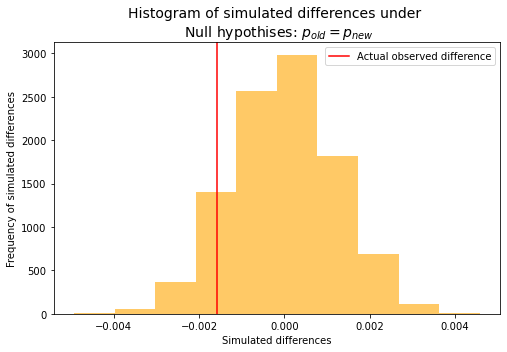

In [26]:
## Actual observed difference in the initial sample (df2)
obs_diff = df2[df2.group=='treatment']['converted'].mean() - df2[df2.group=='control']['converted'].mean()
## Plotting histogram and indicating actual observed difference
plt.figure(figsize = (8,5));
plt.hist(p_diffs, alpha = 0.6, color = 'orange');
plt.axvline(x=obs_diff, color = 'red', label = 'Actual observed difference');
plt.title('Histogram of simulated differences under \n Null hypothises: $p_{old}=p_{new}$', fontsize=14);
plt.xlabel('Simulated differences')
plt.ylabel('Frequency of simulated differences')
plt.legend()
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
## This is a one sided test. P-value is after observed difference point.
p_v = (p_diffs > obs_diff).mean() 
print('P value for the observed difference: {}'.format(np.round(p_v,4)))

P value for the observed difference: 0.9012


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> # Answer
> Calculated value is the p-value. The value says that there are over 90% chance we are making type I error if we conclude that treatement group have higher convertion rate. Since, this value is greater than threshold 5%, we do not see any evidence to reject null hypothises.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2[df2.landing_page=='old_page']['converted'].sum()
convert_new = df2[df2.landing_page=='new_page']['converted'].sum()
n_old = (df2.landing_page=='old_page').sum()
n_new = (df2.landing_page=='new_page').sum()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
from statsmodels.stats.proportion import proportions_ztest

count = [convert_old, convert_new]
nobs = [n_old, n_new]
stat, pval = proportions_ztest(count, nobs, 0, 'smaller')

In [30]:
print("Z-score: {} and p-value: {}".format(np.round(stat,4), np.round(pval,5)))

Z-score: 1.3109 and p-value: 0.90506


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> # Answer
> Z-score tells us that observed difference is 1.31 standard deviations from the 0. P-value tells us that observed difference can be a type I error with 90% chance. Our threshold to reject null is z-score should be greater than 1.645 or p-value less than 5%. Both significance levels not passed, hence null hypothises not rejected. The exercise agrees with the conclusion in previous analysis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> # Answer
> The outcome is non-linear. Suggested model is Logistic Regression Model.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1 # Intercept
df2['ab_page'] = pd.get_dummies(df2['group']).drop('control', axis=1) # Treatement dummy

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
import statsmodels.api as sm
y = df2['converted']
x = df2[['intercept', 'ab_page']]
model = sm.Logit(y, x).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-04-22 16:38 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> # Answer
> The p-value is 0.1899. The null and alternative hypothises in part II are $H_0: p_{old} \geq p_{new} = 0$ and $H_1: p_{old} < p_{new}$ respectively, which requires one-sided test. In part III, they are $H_0: p_{new} = p_{old}$ and $H_1: p_{old} \neq p_{new}$ requiring two sided test. While one-sided test calculates p-value from the area to the right of the observed point, the two sided test calculates p-value from both tails of the distribution, taking difference as absolute value.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> It would be better to include other variables, since our pseudo-R squared is close 0 it's prediciton power is very low. Variables such as time is a good candidate, since new-page might have not worked during earlier periods, but after some time user might have used to it and clicked more often. Disadvantages might arise in terms of multicollinearity issue, where one variable might be correlated with another and influence the true signs of the estimates.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
## Adding countries into the dataframe
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
### Create the necessary dummy variables
df_new[['CA', 'UK']] = pd.get_dummies(df_new['country']).drop('US', axis=1)

In [38]:
### Fitting a lineal logit model with independent variables as country
y = df_new['converted']
x = df_new[['intercept', 'CA', 'UK']]
model2 = sm.Logit(y, x).fit()
model2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2023-04-22 16:39 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

> ## Answer
> It looks like countries separately do not have statistical significant realtionship with convertion rate. Both estimates are close to zero and have p values of greater than threshold values.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
### getting interaction terms CA#ab_page, UK#ab_page
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
x = df_new[['intercept', 'ab_page', 'CA', 'CA_ab_page', 'UK', 'UK_ab_page']]
### Fit Linear Model And Obtain the Results
model3 = sm.Logit(y,x).fit();
model3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2023-04-22 16:39 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

> ## Answer
>Adding new variables and interactions did not add any significant value to the model. Sign of the tratement variable did not change, although p value decreased. The estimates are still insignificant under 5% threshold level. This approach also confirms that new page is not increasing convertion rate.

<a id='conclusions'></a>
> ## Conclusions

> Within this project we used simulation, logistic regression and built-in packages to find out whether convertion rate changes when new landing page is used. Our analysis shows that new landing page does not statistically impact convertion rate and at most it might even decrease the convertion rate.

> The above statistical analysis brings us to suggest not to use new landing page.